# <a id='title'><p style='text-align: center'>Correlating Clinical and MRI Results to Dementia Diagnosis</p></a>

### <p style='text-align: center'>Mark C. Capece<sup>1</sup></p>

#### <p style='text-align: center'><sup>1</sup>Python Data Science Program, RMOTR</p>



##### <p style='text-align: center'>Keywords: Dementia, Alzheimer's Disease, MRI, OASIS, Machine Learning, Deep Learning</p>

## <a id='abstract'>Abstract</a>
<p style='text-align: justify'>Dementia lacks a definitive physiological marker, so diagnosis requires the correlation of a number of orthogonal measurements, such as changes in mental state, behavior, and brain chemistry. It would be attractive to automate the diagnosis of dementia using algorithms that can correlate these measurements rapidly and consistently. This exploratory work applied existing models of supervised machine learning to identify patients with dementia from a 608-patient dataset containing  feature parameters of age, education, socioeconomic status, Mini-Mental State Exam score, normalized whole brain volume, and estimated total intracranial volume. Several models successfully achieved five-fold mean cross-validation accuracies in excess of 80%, the best of which was the Adaptive Boosting Classifier, which achieved 89 $\pm$ 3% accuracy. Feed-forward neural network models consistently reported the lowest accuracy. It is likely that larger datasets with more extensive features could achieve greater accuracy.</p>

## <a id='intro'>Introduction</a>

<p style='text-align: justify'>Dementia is neurocognitive disorder characterized by the loss of cognitive function and memory to an extent that impacts an individual's ability to function (American Psychiatric Association 2013). Difficulty speaking and anomia, emotional distress or paranoia, impaired problem solving, and loss of motivation are also common symptoms. Neurodegeneration often occurs slowly and symptoms may go undetected for many years. The earliest stage of dementia is Mild Cognitive Impairment (MCI), in which symptoms are first beginning to show but the individual is still capable of caring for his or herself. In 70% of cases, MCI leads to further degradation (Budson and Solomon 2011). In these mild stages of dementia, symptoms become obvious and begin to impact daily life. Further progression to moderate dementia generally impairs memory, problem-solving, and behavior control, often requiring a caregiver to assist daily activities. Finally, severe or late-stage dementia completely eliminates the individual's ability to perform even simple tasks, such as getting out of bed, eating, and using the restroom. Approximately 5-7% of individuals over the age of 60 years old are diagnosed with dementia worldwide, and the computed total cost of caring for the demented in the United States alone in 2010 was over $100 billion (Prince et al. 2012; Hurd et al. 2013).</p>
    
<p style='text-align: justify'>Dementia can result from many different neurodegenerative conditions, including  Alzheimer's Disease, strokes (vascular dementia), and, in some cases, congenital defects (Loy et al. 2014). Most cases of dementia are causes by Alzheimer's Disease, which is characterized by short-term memory loss, anomia, loss of spatial awareness, and impaired reasoning (Burns 2009). While the precise mechanistic cause of Alzheimer's Disease remains unknown, it has been proposed that accumulation of $\beta$-amyloid plaques kills neuronal cells, effecting atrophy in the hippocampus (Hardy and Allsop 1991).</p>
    
<p style='text-align: justify'>Early diagnosis of dementia can be difficult, as symptoms can go unnoticed for years. Furthermore, symptoms of depression, psychosis, and delirium can convolute a dementia diagnosis. The Mini-Mental State Examination (MMSE, or Folstein test) is the most commonly used cognitive test for dementia (Folstein et al. 1975; Pangman et al. 2000). This 5-10 min diagnostic procedure evaluates the patient's ability to keep attention, perform simple arithmetic, recall words, and follow commands (Tuijl et al. 2012). Correct responses earn points up to a maximum score of 30, which indicates a healthy, nondemented mental state. Scores below 24 typically  suggest some degree of dementia (19-23 is mild, 10-18 is moderate, and below 9 is severe). The MMSE results are sensitive to age, education, and cultural background, but are not affect by the patient's sex (Tombaugh et al. 1992). Once symptoms have manifested, laboratory tests can be performed to identify non-neurological  dysfunctions, such as vitamin deficiencies and infections, that can cause reversible dementia. Computated tomography (CT) and magnetic resonance imaging (MRI) scanning are frequently used to confirm brain atrophy once symptoms are apparent, as well as identifying vascular dementia (Fotenos et al. 2005). More recent advancements in positron emission tomography (PET) and single-photon emission computed tomography (SPECT) have been very successful in predicting dementia, as well as differentiating Alzheimer's Disease and vascular dementia (Bonte et al. 2006; Valotassiou et al. 2018). A dementia diagnosis is further qualified by its score in the Clinical Dementia Rating scale (CDR) (Morris 1993). The possible CDR values are 0 (no symptoms or nondemented), 0.5 (very mild), 1 (mild), 2 (moderate), and 3 (severe). Like the MMSE, a CDR score is given according to patient responses to an interview testing memory, problem solving, and behavior. Despite the inherent subjectivity of response interpretation, CDR scores have been found to be consistent across multiple raters ($\kappa = 0.62$) (Rockwood et al. 2000).</p>

<p style='text-align: justify'>Machine learning is the process by which computers build mathematical models to study data. The models are trained against known datasets. If inputs and their correct outputs are included in the training set, the machine learning is said to be supervised. Once trained, the model can be tested against out-of-sample data without the desired outputs to evaluate accuracy, goodness of the fit, potential overfitting. Accuracy and goodness of fit are highly dependent on proper input selection, and the naive inclusion of all possible inputs can be inefficient and counterproductive. In an effort to reduce the number of inputs while retaining as much predictive information in the input dataset, principal component analysis can be performed to transform the dataset into an equivalent orthogonal frame. Redundant or low-variance dimensions can be dropped without sacrificing information. Many supervised machine learning algorithms have been developed for classification problems, such as labeling an image or making a diagnosis. Decision trees break down the inputs into a series of conditional statements that create branches that split into leaves (class labels). A number of variations to the decision tree have been made. Boosted trees (gradient and adaptive) are weighted ensembles of decision trees designed to transform a multitude of weak-learning models into one strong learner. The random forest is a collection of decision trees with different branches and leaves treated individually. The output of the random forest is the most common result label of all of the decision trees in the collection. Nearest neighbor classification assigns labels to data points according to their nearest neigbor labels. Support vector machines attempt to project the input data into higher-dimensional spaces and create clear distinction between points of different output labels. Bayesian networks map input interdependence to evaluate probabilitstic relationships. Finally, artificial neural networks construct a series of hidden layers that connect an input to its output class. Each layer is composed of neurons, which nonlinearly transform an incoming vector or matrix. During training, incorrect outputs force the hidden transformation matrices to change while correct outputs reinforce the current parameters.</p>

<p style='text-align: justify'>Due to widespread access to plentiful medical data, machine learning has been applied extensively to medical research (Deo 2015). Successful applications have achieved advancements in breast cancer and heart disease detection. Competitions are even being sponsored to engange the artificial intelligence community to collaboratively solve clinical research problems. In this vein of interdisciplinary research, this work presents an effort to correlate limited behavioral and MRI data to dementia diagnoses using eight supervised machine learning models.</p>

## <a id='methods'>Materials and Methods</a>

### Data Access
<p style='text-align: justify'>The dataset "MRI and Alzheimers: Magnetic Resonance Imaging Comparisons of Demented and Nondemented Adults" was uploaded to [Kaggle](https://www.kaggle.com/jboysen/mri-and-alzheimers) by user Jacob Boysen on August 16, 2017. This dataset is provided by the [Open Access Series of Imaging Studies](https://oasis-brains.org/) (OASIS), which also hosts this dataset on its website. The data is divided into two parts: a OASIS1, cross-sectional study of 416 patients (Marcus et al. 2007), and OASIS2, a longitudinal study of 150 patients across 373 sessions (Marcus et al. 2010). The data was accessed and processed in an iPython notebook environment.</p>

### Imported Dataset Properties
<p style='text-align: justify'>The cross-sectional OASIS1 dataset and longitudinal OASIS2 dataset feature 11 and 13 properties, respectively, indexed by patient-visit identifier ("ID" in OASIS1 and "MRI ID" in OASIS2). The patient-visit identifier is structured in three parts separated by underscores: the abbreviated dataset name "OAS1" or "OAS2", the integer patient identifier zero-padded to four digits, and the number of the MRI visit starting with "MR1." Thus, the first entry in the OASIS1 dataset is indexed "OAS1_0001_MR1."</p>

* M/F (renamed to Sex) is the biological sex, male or female, of the patient.

* Hand is the dominant handedness, right or left, of the patient. All patients in this study were right-handed.

* Age is the age, in years, of the patient.

* Educ (renamed to Edu) is the educational level of the patient. In OASIS1, this level is categorized into integers from 1 to 5: 1 is less than high school, 2 is high school graduate, 3 is some college, 4 is college graduate, and 5 is postgraduate education. In OASIS2, educational level is reported as school years, so that integers less than 12 indicate less than high school, 12 is high school graduate, 13-15 is some college, 16 is college graduate, and integers greater than 16 are postgraduate education.

* SES is the socioeconomic status of the patient codified as an integer from 1 to 5 in terms of descending wealth.

* MMSE is the Mini Mental State Exam score of the patient as an integer from 1 to 30 in terms of decreasing dementia.

* CDR is the Clinical Dementia Rating of the patient. Ratings of 0 indicate no dementia, 0.5 is very mild dementia, 1 is mild dementia, and 2 is moderate dementia.

* eTIV is the estimated total intracranial volume of the patient. eTIV is calculated as $\frac{1755}{ASF}$ cm$^{3}$ according to Buckner et al. (2004).

* nWBV is the normalized whole brain volume of the patient as measured by MRI. nWBV is calculated as the precentage of white and gray-matter voxels within the atlas brain mask (Buckner et al. 2004).</p>

* ASF is the atlas scaling factor of the patient as measured by MRI. ASF is calculated as the determinant of the transformation matrix that maps the patient's brain volume onto the derived atlas model. Large native intracranial volumes generated ASF values less than one, while small native intracranial volumes generated ASF values between one and two (Buckner et al. 2004).

* Delay in the OASIS1 dataset and _MRI Delay_ in the OASIS2 dataset are the number of days after the first MRI visit.

* Visit in the OASIS2 dataset only is the number of the MRI visit, starting with 1.

* Group in the OASIS2 dataset only is a categorization of the patient as either "Nondemented" (CDR of 0 in all visits), "Demented" (CDR > 0 in all visits), or "Converted" (CDR of 0 in first visit, and CDR > 0 in subsequent visit).

### Data Transformation

<p style='text-align: justify'>The raw OASIS1 and OASIS2 datasets were downloaded locally as CSV files. Reading and transforming the OASIS datasets were performed with the transform_data function. This function imported the datasets as pandas DataFrames and renamed the columns 'EDUC' and 'M/F' as 'Edu' and 'Sex,' respectively. A 'Group' column was added to the OASIS1 dataset by categorizing each patient as "Nondemented" or "Demented" according to their CDR scores. Patients without a CDR score (NaN), which were typically people under the age of 40, were removed from the dataset. Furthermore, the 'Group' column of the OASIS2 dataset was modified to remove the "Converted" category, so that each entry was considered individually as "Nondemented" or "Demented" according to the results of the visit. Both datasets were merged into a single dataset incorporating all of the samples and properties of OASIS1 and OASIS2 for further analysis. The function returned a tuple representing the OASIS1, OASIS2, and combined DataFrames, respectively. For transformation into a principal component axis frame, the function principal_component_transformation was created. The principal_component_transformation function returned the fitted PCA parameters and the transformed DataFrame.</p>

### The Analysis Object

<p style='text-align: justify'>An object class called Analysis was designed to contain all of the analysis and machine learning functions. When instanced, the class takes a DataFrame, list of feature column names, list of target column names, and boolean scale and nn flags. The feature inputs are automatically organized into a separate DataFrame attribute and scaled according to $z = \frac{x - \bar{x}}{\sigma}$. The target ouputs are also separated into another DataFrame attribute. Feature analysis was performed using the correlations, violin_plots, three_d_plots, stats_table, and skew_and_kurtosis methods. Machine learning was performed using the machine_learning and ml_table methods. The machine_learning method trained and tested a given list of machine learning algorithms against the instance's input and output attributes. The ml_table method performed combinatorics to create an array of all possible combinations of features and instanced temporary Analysis objects that executed their own machine_learning methods using their individual feature combinations.</p>

### Feature Analysis

<p style='text-align: justify'>In the combined dataset, Group values were considered target dementia diagnoses, and the numerical properties of ASF, Age, Edu, MMSE, SES, eTIV, and nWBV were considered feature inputs. These features were analyzed for correlation using a pandas scatter matrix. These properties were also displayed as violin plots divided by Group and split by Sex and as a table of means and standard deviations to examine the distribution of the data. The skew and kurtosis of each future distribution was also examined.</p>

### Machine Learning Algorithms

<p style='text-align: justify'>Eight supervised machine learning algorithms from the Scikit-Learn API (Pendregosa et al. 2011) were applied to the combined dataset: Decision Trees (DecisionTreeClassifier), Random Forest (RandomForestClassifier), Gaussian Naive Bayes (GaussianNB), Nearest Neighbors (KNeighborsClassifier), Support Vector Machine (SVC), Multilayer Perceptron (MLPClassifier), Adaptive Boost (AdaBoostClassifier), and Gradient Boost (GradientBoostingClassifier). The feature inputs were first reduced to their principal components, minimizing feature dimensionality to retain at least 95% of the dataset variance. An accumulation approach was used to collect the list of principal components (PC1, PC1+PC2, PC1+PC2+PC3, and so on) as inputs to the machine learning algorithms. The target outputs were an enumerated Group property (0 for Nondemented, 1 for Demented). For each algorithm, model parameters were optimized using the GridSearchCV function trained against a dynamically-selected training and testing sample set according to the train_test_split function. The parameters resulting in the greatest accuracy were then used in a %k%-fold ($k=5$) cross-validation analysis of the entire combined dataset. To elucidate which features contain the most predictive information, this process was repeated for the individual raw features in the native dataset frame. All 127 possible combinations of the seven native features were used to train all eight supervised machine learning algorithms.</p>

In [1]:
# Import ----------------------------------------------------------------------
# --Python
from itertools import accumulate, combinations
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

# --Scikit Learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# --Local
from dementia.utilities import transform_data, principal_component_transformation
from dementia.analysis import Analysis

# iPython ---------------------------------------------------------------------
%matplotlib inline

In [2]:
# Load and combine datasets
cross, long, data = transform_data()

data.head()

,ASF,Age,CDR,CDR_Group,Delay,Demented,Edu,Group,Hand,MMSE,MR Delay,Nondemented,SES,Sex,Subject ID,Visit,eTIV,nWBV,num_group,num_sex
OAS1_0001_MR1,1.306,74,0.0,0.0,NaN,0,2.0,Nondemented,R,29.0,NaN,1,3.0,F,NaN,NaN,1344,0.743,0,0
OAS1_0002_MR1,1.531,55,0.0,0.0,NaN,0,4.0,Nondemented,R,29.0,NaN,1,1.0,F,NaN,NaN,1147,0.810,0,0
OAS1_0003_MR1,1.207,73,0.5,0.5,NaN,1,4.0,Demented,R,27.0,NaN,0,3.0,F,NaN,NaN,1454,0.708,1,0
OAS1_0010_MR1,1.073,74,0.0,0.0,NaN,0,5.0,Nondemented,R,30.0,NaN,1,2.0,M,NaN,NaN,1636,0.689,0,1
OAS1_0011_MR1,1.329,52,0.0,0.0,NaN,0,3.0,Nondemented,R,30.0,NaN,1,2.0,F,NaN,NaN,1321,0.827,0,0


In [3]:
# Define Feature, Target, and ML model lists
features = ['Age', 'Edu', 'SES', 'MMSE', 'nWBV', 'eTIV', 'ASF']
pc_features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

targets = ['num_group']

model_list = [DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier(), MLPClassifier(), 
              SVC(), AdaBoostClassifier(), GradientBoostingClassifier(), RandomForestClassifier()]

## <a id='results'>Results and Discussion</a>

### Feature Analysis

<p style='text-align: justify'>Sex: Of the 608 patients in the combined dataset, 369 (61%) patients were female and 239 (39%) patients were male for a sex ratio of 0.65. 35% of the female patients were diagnosed with at least very mild dementia, while 57% of the male patients had a positive diagnosis. The greatest CDR reported was 2 (moderate dementia), and only 3 (less than 1%) women and 2 (less than 1%) men received this diagnosis. The studies' bias toward female patients may be a result of patient availability, where a higher life expectancy means that more women were able to participate. Differences in the prevalence of dementia in men and women are still uncertain, so it is unclear whether the skew in diagnoses is significant (Mielke 2018).</p>

<p style='text-align: justify'>Age: Patients' ages are distributed around a mean of 75.2 $\pm$ 9.7 years. This distribution deviates from normal with a skew of -0.73 and kurtosis of 1.16, indicating a long tail of young patients. Demented patients are, on average, 76.8 $\pm$ 7.1 years old, while unafflicted patients are 74.0 $\pm$ 11.4 years old. These statistics are reasonable, since the primary risk factor for dementia is age.</p>

<p style='text-align: justify'>Edu: 46 (7.6%) patients did not finish high school, 167 (27.5%) held terminal high school diplomas, 124 (20.4%) had some college education, 131 (21.5%) held terminal undergraduate degrees, and 140 (23.0%) earned postgraduate degrees. Men were slightly more educated on average (3.2 $\pm$ 1.3 vs 3.4 $\pm$ 1.3), which agrees with social trends. Nondemented patients were also more educated on average (2.9 $\pm$ 1.3 vs 3.5 $\pm$ 1.2), which follows from studies that found low education to be a risk factor for dementia.</p>

<p style='text-align: justify'>SES: From 1 to 5 in order of decreasing socioeconomic status, patients were distributed as 138 (22.7%), 168 (27.6%), 131 (21.5%), 123 (20.2%), and 10 (1.6%). 38 (6.3%) patients were not assigned a SES score. In accordance with education, men had slightly better SES (2.4 $\pm$ 1.2  vs 2.5 $\pm$ 1.1), and nondemented patients also reported a better SES (2.3 $\pm$ 1.1 vs 2.7 $\pm$ 1.2).</p>

<p style='text-align: justify'>MMSE: MMSE was the primary distinguishing characteristic between nondemented and demented patients. Unafflicted persons reported a MMSE score of 29.2 $\pm$ 1.0, while those with dementia received a MMSE score of 24.7 $\pm$ 4.3. All nondemented patients had a MMSE greater than 25, while demented patients' scores ranged from 4 to 30.</p>

<p style='text-align: justify'>nWBV: Overall, nWBV values were approximately normally distributed (skew = 0.27, kurtosis = -0.50) around a mean of 0.74 $\pm$ 0.04. In normal patients, nWBV was reported as 0.75 $\pm$ 0.04, while demented patients were moderately lower at 0.72 $\pm$ 0.03. Since nWBV exhibits a strong negative correlation with Age ($m = -0.003$, $b = 0.948$, $r = -0.648$) even among unafflicted patients, it is possible that the correlation between Age and dementia is largely the result of nWBV decay with progressing Age.</p>

<p style='text-align: justify'>ASF: The scaling factor used to transform the native brain volume to that of the atlas model did not have a correlation to any of the previous numerical properties or to a dementia diagnosis. This result is reasonable, because absolute brain size would not be expected to impact neurodegeneration. ASF differed significantly between men (1.11 $\pm$ 0.11) and women (1.26 $\pm$ 0.11), reflecting the tendency for men to have physically larger brains on average.</p>

<p style='text-align: justify'>eTIV: Since eTIV is inverse proportional to ASF, a strong negative correlation ($r = -0.989$) between the two parameters was expected. Furthermore, eTIV did not correlate with dementia diagnosis. Male eTIV values (1597 $\pm$ 163) were consistently larger than female eTIV (1399 $\pm$ 123), since men have physically larger brains on average.</p>

<p style='text-align: justify'>The numerical features with the strongest correlations to dementia diagnoses were Age, Edu, SES, MMSE, and nWBV. ASF and its derived feature eTIV did not have a clear corrleation with dementia. While sex can be enumerated into an integer representation (perhaps 0 for female, 1 for male), the patient population in this dataset is skewed towards a low sex ratio with higher-than-normal dementia diagnoses. Thus, sex was not added as a testing input. The remaining seven features were applied to machine learning as inputs.</p>

In [4]:
# Create new Analysis instance using the combined data and corresponding features and targets
analysis = Analysis(data, features, targets, scale=True)

<Figure size 1152x864 with 0 Axes>

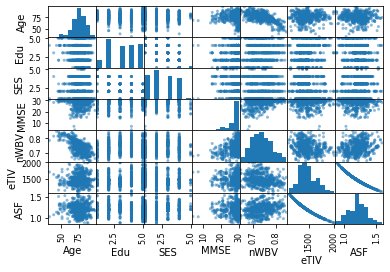

,Age,Edu,SES,MMSE,nWBV,eTIV,ASF
Age,1.000000,-0.111249,0.047150,-0.084787,-0.647799,0.057413,-0.050130
Edu,-0.111249,1.000000,-0.736949,0.242494,0.083734,0.196607,-0.176956
SES,0.047150,-0.736949,1.000000,-0.188485,0.002580,-0.234292,0.223962
MMSE,-0.084787,0.242494,-0.188485,1.000000,0.377745,-0.019059,0.027136
nWBV,-0.647799,0.083734,0.002580,0.377745,1.000000,-0.222960,0.224229
eTIV,0.057413,0.196607,-0.234292,-0.019059,-0.222960,1.000000,-0.989135
ASF,-0.050130,-0.176956,0.223962,0.027136,0.224229,-0.989135,1.000000


In [66]:
# Report interfeature correlations
analysis.correlations()

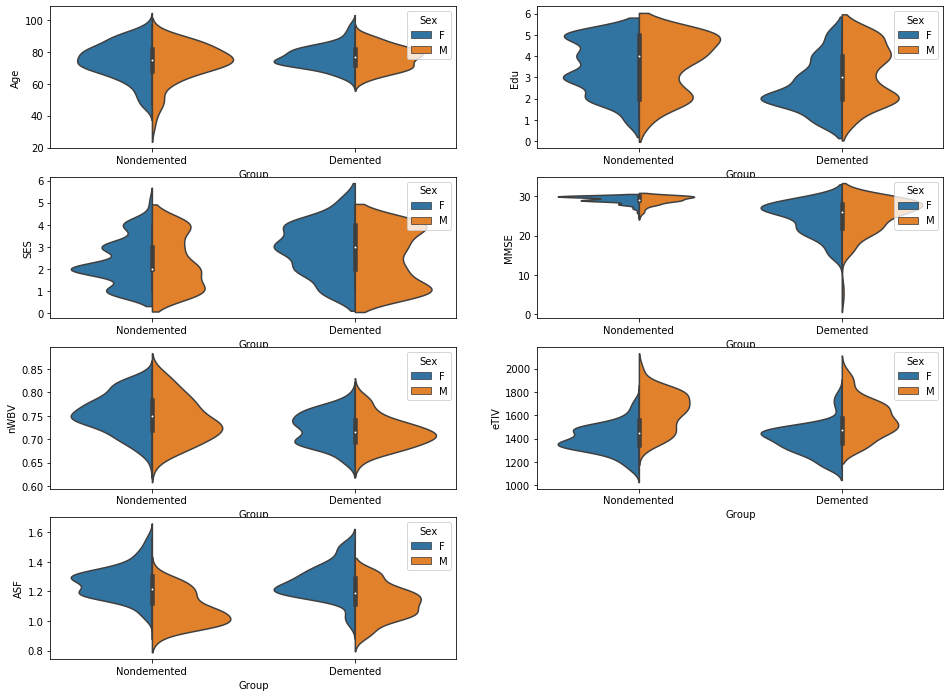

In [64]:
# Plot feature distributions
analysis.violin_plots('Group', 'Sex')

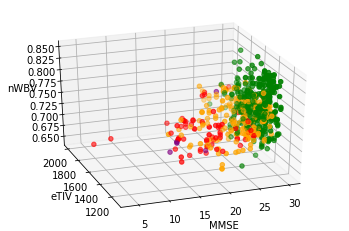

In [7]:
# Plot example 3D scatter plot
analysis.three_d_plot(['MMSE', 'eTIV', 'nWBV'])

In [8]:
# Report feature statistics
analysis.stats_table()

Features          Age                  Edu                 SES            \
Statistics       mean        std      mean       std      mean       std   
0           73.956012  11.445567  3.516129  1.245180  2.333333  1.053781   
1           76.808989   7.074591  2.910112  1.259315  2.675325  1.202623   

Features         MMSE                nWBV                   eTIV              \
Statistics       mean       std      mean       std         mean         std   
0           29.173021  1.007022  0.751845  0.043233  1468.914956  170.811993   
1           24.739623  4.331454  0.718337  0.033670  1487.468165  170.203908   

Features         ASF            
Statistics      mean       std  
0           1.210393  0.136034  
1           1.194918  0.133629

In [9]:
# More feature statistics
analysis.skew_and_kurtosis()

,Skew,Kurtosis
Age,-0.727202,1.160860
Edu,-0.036131,-1.225921
SES,0.199024,-1.101424
MMSE,-2.061358,5.235330
nWBV,0.265585,-0.503772
eTIV,0.545001,-0.008311
ASF,0.035466,-0.220540


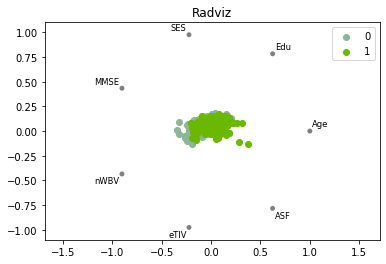

In [10]:
# Plot higher-dimensional representation of features as Radviz
pd.plotting.radviz(data[features + targets], targets[0])
plt.title('Radviz')
plt.show()

### Feature Decomposition

<p style='text-align: justify'>The reduce the dimensionality of the seven features, principal component analysis (PCA) was employed. 95% of the dataset variance was retained in the first five principal components. The variance ratio of these components were 0.34, 0.29, 0.18, 0.12, and 0.04 for a total variance fraction of 0.96. PC1 was largely composed of eTIV and ASF features; PC2 represented nWBV and Age; PC3 was a combination of Age, Edu, and SES; PC4 was aligned closely along MMSE; and PC5 was dominated by nWBV. Overall, Age was represented the most in the principal component frame, and eTIV and ASF were represented the least. Since principal component decomposition attempts to transform the data into a frame with maximum uncorrelated variance, this result indicated that the eTIV and ASF features contain the least uncorrelated variance.</p>

In [11]:
# Perform PCA decomposition
pca, pc_data = principal_component_transformation(data, features, targets)

In [82]:
# Principal components (vectors in terms of feature dimensions)
principal_components = pca.components_

# Feature importance in principal components
print('Overall importance')
rel_import = np.abs(principal_components).sum(axis=0) / np.abs(principal_components).sum()
for f, p in enumerate(rel_import):
    print('{:<4}: {:2.0%}'.format(features[f], p))
    
print('\nMost important in each component')
for n, i in enumerate(principal_components):
    print('PC{}: {}'.format(n+1, features[np.abs(i).argmax()]))

Overall importance
Age : 17%
Edu : 16%
SES : 16%
MMSE: 14%
nWBV: 15%
eTIV: 11%
ASF : 11%

Most important in each component
PC1: eTIV
PC2: nWBV
PC3: Age
PC4: MMSE
PC5: nWBV


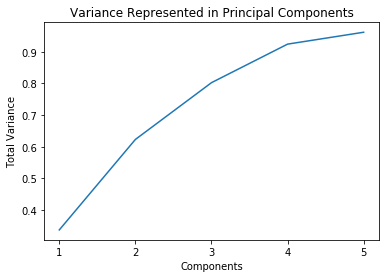

In [63]:
# Variance contained in each principal component
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(range(5), range(1, 6))
plt.title('Variance Represented in Principal Components')
plt.ylabel('Total Variance')
plt.xlabel('Components')
plt.show()

### Machine Learning Algorithms

<p style='text-align: justify'>Eight machine learning models were trained against the dataset within the principal component frame. Five input collections were used: PC1, PC1 and PC2, PC1 through PC3, PC1 through PC4, and all five principal components together. The 5-fold cross-validation scores for all algorithms generally started in the 55-60% accuracy range for PC1 alone and improved significantly as principal components inputs were added. The model with the overall highest accuracy (89 $\pm$ 4%) was the AdaBoostClassifier trained against the PC1 through PC4 using a base Random Forest Classifier with 1000 estimators and a learning rate of 1.0. The worst model was the Gaussian Naive Bayes algorithm with a maximum accuracy of 76 $\pm$ 6%. The Nearest Neighbors model was the only algorithm to noticeably improve with the addition of the fifth principal component (81 $\pm$ 4% to 83 $\pm$ 4%); all other models either marginally lost accuracy or did not change. </p>

In [28]:
# Machine learning in principal component frame
# --Create Analysis object
pc_analysis = Analysis(pc_data, pc_features, targets, scale=False)

# --Load saved PKL results; if results don't exist, run ml_table to generate results
try:
    pkld_pc_full = pd.read_pickle('PKLs/190812_pc.pkl')
    pkld_pc_full_mean = pd.read_pickle('PKLs/190812_pc_mean.pkl')
except FileNotFoundError:
    pc_analysis_full = pc_analysis.ml_table(models=model_list, array='acc')
    pc_analysis_full.to_pickle('PKLs/190812_pc.pkl')
    pkld_pc_full_mean = pkld_pc_full.xs('mean', level=1).astype('float64')
    pkld_pc_full_mean.to_pickle('PKLs/190812_pc_mean.pkl')

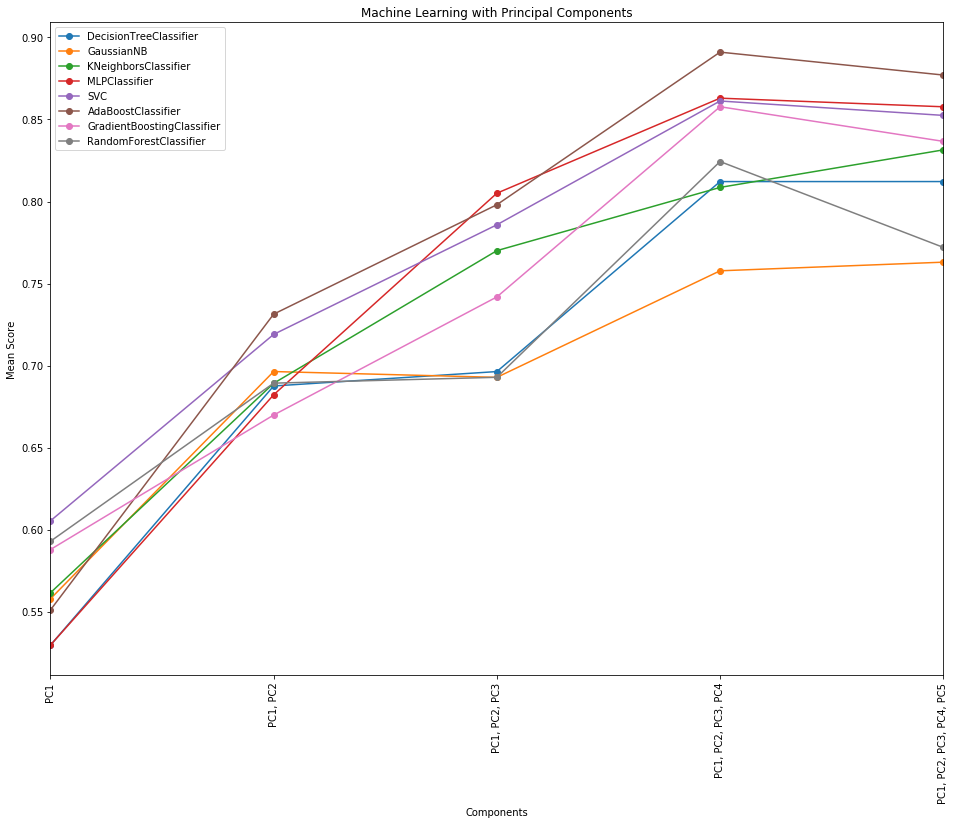

In [60]:
# Plot ML results
fig, ax = plt.subplots(figsize=(16, 12))
pkld_pc_full_mean.plot(style='o-', ax=ax)
plt.xticks(range(len(pkld_pc_full_mean.index)), 
           pkld_pc_full_mean.index, 
           rotation=90)
plt.title('Machine Learning with Principal Components')
plt.ylabel('Mean Score')
plt.xlabel('Components')
plt.legend(loc='best')
plt.show()

In [38]:
# Print best scores for each model
print('{:<30}: {:<30}: {} ({})'.format('Model', 'Components', 'Score', 'Stdev'))
for m in pkld_pc_full.columns:
    imax = pkld_pc_full[m].xs('mean', level=1).astype('float64').idxmax()
    print('{:<30}: {:<30}: {:1.3f} ({:1.3f})'.format(m, 
                                                     imax, 
                                                     pkld_pc_full[m].xs('mean', level=1).loc[imax],
                                                     pkld_pc_full[m].xs('std', level=1).loc[imax]))

Model                         : Components                    : Score (Stdev)
DecisionTreeClassifier        : PC1, PC2, PC3, PC4, PC5       : 0.812 (0.035)
GaussianNB                    : PC1, PC2, PC3, PC4, PC5       : 0.763 (0.056)
KNeighborsClassifier          : PC1, PC2, PC3, PC4, PC5       : 0.831 (0.035)
MLPClassifier                 : PC1, PC2, PC3, PC4            : 0.863 (0.035)
SVC                           : PC1, PC2, PC3, PC4            : 0.861 (0.029)
AdaBoostClassifier            : PC1, PC2, PC3, PC4            : 0.891 (0.043)
GradientBoostingClassifier    : PC1, PC2, PC3, PC4            : 0.858 (0.035)
RandomForestClassifier        : PC1, PC2, PC3, PC4            : 0.824 (0.056)


<p style='text-align: justify'>To investigate which of the seven native features carried the most predictive value, 127 combinations of the features of total length ranging from single features to all seven together were used to train the eight supervised machine learning algorithms. It is immediately apparent that accuracy scores for all algorithms achieved maxima when MMSE was included as an input. The absolute highest accuracy across all models and inputs was 89 $\pm$ 4% for the adaptive boost classifier trained against Age, Edu, SES, MMSE, eTIV, and ASF features. The adaptive boost parameters used 10 estimators and a learning rate of 1.0. The gradient boosting classifier was just below the maximum at 88 $\pm$ 3% when trained against Age, Edu, SES, MMSE, and eTIV. The multilayer perceptron classifier underperformed with a score maximum of only 81 $\pm$ 5% when trained against Edu, MMSE, and ASF. Additional features did not improve the multilayer perceptron model.</p>

<p style='text-align: justify'>When only considering input groups that included MMSE, all algorithms achieved at least 80% accuracy with MMSE as the sole feature. For adaptive and gradient boosting algorithms, additional features generally improved model scores proportionally to the number of features up to the previously-described maxima. In contrast, additional features decreased performance for multilayer perceptron, nearest neighbor, and support vector classifiers. Simple decision trees, random forests, and Gaussian Naive Bayes models were not significantly affected by expanding the input dimensions. These results support the observation that MMSE is the primary distinguishing characteristic in the data set. Since the Mini-Mental State Exam is similar to the Clinical Dementia Rating in that both scores reflect the stage of dementia afflicting the patient according to observable behavioral changes. Thus, MMSE could be considered to be excessively correlated to CDR, making MMSE an unreasonable feature for machine learning.</p>
    
<p style='text-align: justify'>When MMSE was excluded from the input groups, the overall maximum accuracy score was decreased to 82 $\pm$ 6%, which resulted from the adaptive boost classifier. The gradient boost classifier was second-best again with an accuracy of 79 $\pm$ 3%. Gaussian naive Bayes, multilayer perceptron, and decision tree classifiers were the least accurate overall. For high-performing models, Age, Edu, nWBV, and ASF were consistently the most informative features. The following paragraphs explore the extent to which different groups of features without MMSE contained predictive information for diagnosing dementia.</p>

<p style='text-align: justify'>Age, Edu, and SES are common demographic data that can be collected rapidly, so it would be attractive to quantify dementia risk from these features. In this study, the maximum accuracy attainable for only demographic features was 68 $\pm$ 8% with the support vector classifier. The SVC parameters that achieved this result used a gamma of 1, the radial basis function kernel, and 0.001 tolerance. The adaptive boost classifier was a close second with 67 $\pm$ 8% accuracy. Decision tree and multilayer perceptron models resulted in the lowest accuracy scores of 59 $\pm$ 9% and 61 $\pm$ 2%, respectively. Most scores reported large standard deviations, because the train and test sample selections greatly affected the model ouput. These models would would be much improved by larger training sets to improve consistency.</p>

<p style='text-align: justify'>nWBV, eTIV, and ASF are MRI-derived features that represent brain atrophy percentage and absolute and relative brain size, respectively. These parameters are desirable features, because imaging is a painless, noninvasive procedure that can be performed repeatedly for the same patient and requires little subjective interpretation. Machine learning algorithms trained against these three features together produced a maximum accuracy score of 76 $\pm$ 4%. Adaptive boost and gradient boost classifiers resulted in the best scores above 70%, and the multilayer perceptron classifier resulted in the worst score below 50%. The remaining models scored between 60% and 70%. As expected, the MRI-derived features were more predictive than demographic features but less predictive than the combination of MRI and demographic features.</p>

In [39]:
# Machine learning in native feature frame
# --Load saved PKL results; if results don't exist, run ml_table to generate results
try:
    pkld_raw_full = pd.read_pickle('PKLs/190812_raw.pkl')
    pkld_raw_full_mean = pd.read_pickle('PKLs/190812_raw_mean.pkl')
except FileNotFoundError:
    raw_analysis_full = analysis.ml_table(models=model_list, array='combo')
    raw_analysis_full.to_pickle('PKLs/190812_raw.pkl')
    pkld_raw_full_mean = pkld_pc_full.xs('mean', level=1).astype('float64')
    pkld_raw_full_mean.to_pickle('PKLs/190812_raw_mean.pkl')

In [43]:
# Print best scores for each model
print('{:<30}: {:<35}: {} ({})'.format('Model', 'Features', 'Score', 'Stdev'))
for m in pkld_raw_full.columns:
    imax = pkld_raw_full[m].xs('mean', level=1).astype('float64').idxmax()
    print('{:<30}: {:<35}: {:1.3f} ({:1.3f})'.format(m, 
                                                     imax, 
                                                     pkld_raw_full[m].xs('mean', level=1).loc[imax],
                                                     pkld_raw_full[m].xs('std', level=1).loc[imax]))

Model                         : Features                           : Score (Stdev)
DecisionTreeClassifier        : Age, SES, MMSE                     : 0.837 (0.043)
GaussianNB                    : Age, SES, MMSE, ASF                : 0.837 (0.048)
KNeighborsClassifier          : Age, SES, MMSE, nWBV, ASF          : 0.838 (0.045)
MLPClassifier                 : Edu, MMSE, ASF                     : 0.812 (0.051)
SVC                           : SES, MMSE, nWBV                    : 0.837 (0.045)
AdaBoostClassifier            : Age, Edu, SES, MMSE, eTIV, ASF     : 0.891 (0.042)
GradientBoostingClassifier    : Age, Edu, SES, MMSE, eTIV          : 0.882 (0.031)
RandomForestClassifier        : SES, MMSE, nWBV, eTIV, ASF         : 0.837 (0.045)


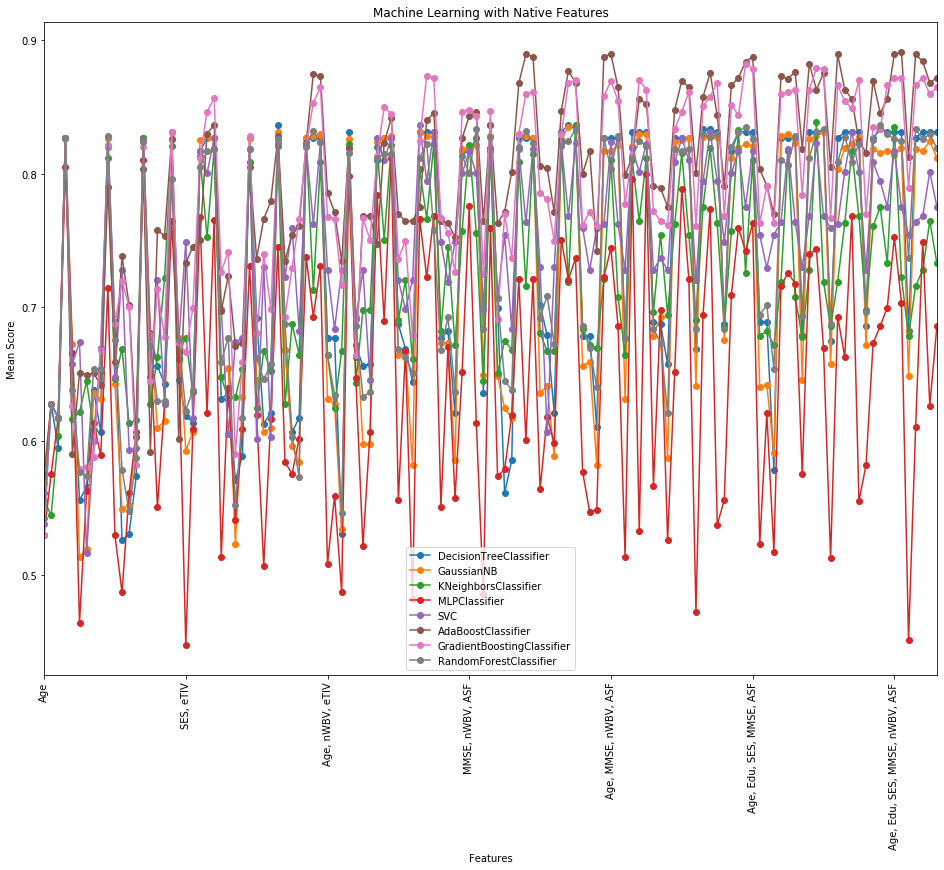

In [84]:
# Plot ML result
fig, ax = plt.subplots(figsize=(16, 12))
pkld_raw_full_mean.plot(style='o-', ax=ax)
plt.xticks(rotation=90)
plt.title('Machine Learning with Native Features')
plt.ylabel('Mean Score')
plt.xlabel('Features')
plt.legend(loc='best')
plt.show()

In [73]:
# Remove ML models trained with MMSE
pkld_raw_full_noMMSE = pkld_raw_full.loc[['MMSE' not in i[0] for i in list(pkld_raw_full.index)]]

# Print best scores for each model
print('{:<30}: {:<35}: {} ({})'.format('Model', 'Features', 'Score', 'Stdev'))
for m in pkld_raw_full_noMMSE.columns:
    imax = pkld_raw_full_noMMSE[m].xs('mean', level=1).astype('float64').idxmax()
    print('{:<30}: {:<35}: {:1.3f} ({:1.3f})'.format(m, 
                                                     imax, 
                                                     pkld_raw_full_noMMSE[m].xs('mean', level=1).loc[imax],
                                                     pkld_raw_full_noMMSE[m].xs('std', level=1).loc[imax]))

Model                         : Features                           : Score (Stdev)
DecisionTreeClassifier        : Age, Edu, nWBV, eTIV               : 0.702 (0.047)
GaussianNB                    : Edu, SES, nWBV, ASF                : 0.693 (0.049)
KNeighborsClassifier          : Edu, SES, nWBV, ASF                : 0.754 (0.043)
MLPClassifier                 : Edu, SES, nWBV, ASF                : 0.698 (0.050)
SVC                           : Age, SES, eTIV                     : 0.760 (0.060)
AdaBoostClassifier            : Age, Edu, nWBV, eTIV, ASF          : 0.819 (0.057)
GradientBoostingClassifier    : Age, Edu, SES, nWBV, ASF           : 0.791 (0.030)
RandomForestClassifier        : Age, Edu, SES, nWBV, eTIV, ASF     : 0.737 (0.049)


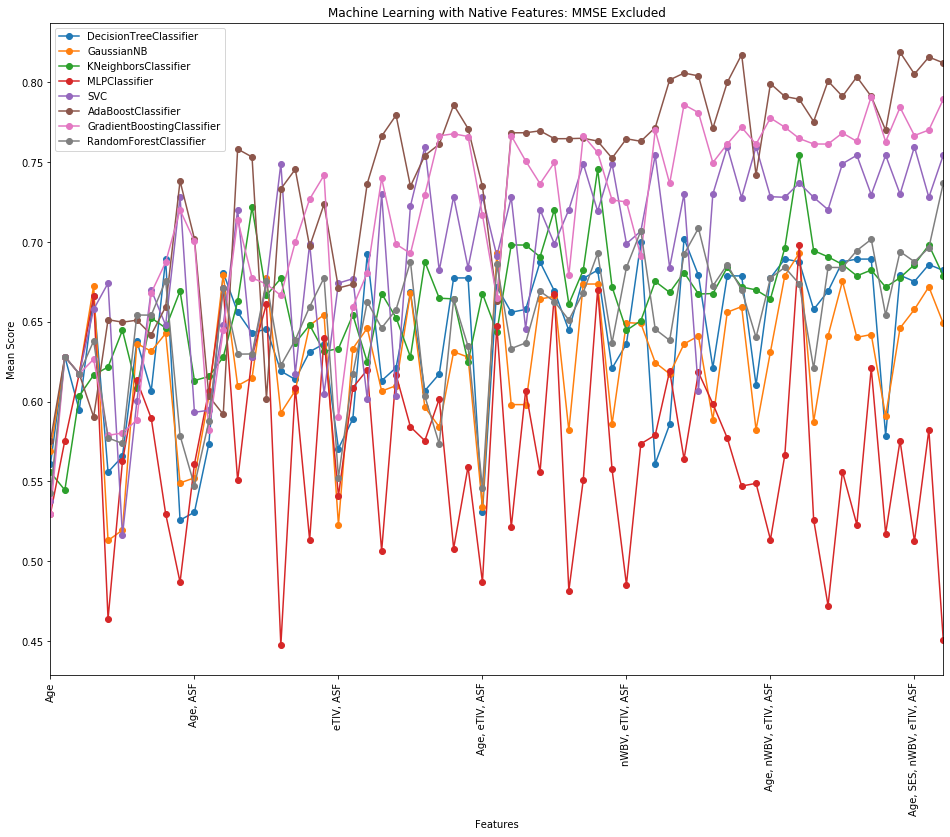

In [85]:
# Plot results without MMSE
pkld_raw_full_noMMSE_mean = pkld_raw_full_noMMSE.xs('mean', level=1)

fig, ax = plt.subplots(figsize=(16, 12))
pkld_raw_full_noMMSE_mean.plot(style='o-', ax=ax)
plt.xticks(rotation=90)
plt.title('Machine Learning with Native Features: MMSE Excluded')
plt.ylabel('Mean Score')
plt.xlabel('Features')
plt.legend(loc='best')
plt.show()

In [76]:
# Only include ML models trained with MMSE
pkld_raw_full_onlyMMSE = pkld_raw_full.loc[['MMSE' in i[0] for i in list(pkld_raw_full.index)]]

# Print best scores for each model
print('{:<30}: {:<35}: {} ({})'.format('Model', 'Features', 'Score', 'Stdev'))
for m in pkld_raw_full_onlyMMSE.columns:
    imax = pkld_raw_full_onlyMMSE[m].xs('mean', level=1).astype('float64').idxmax()
    print('{:<30}: {:<35}: {:1.3f} ({:1.3f})'.format(m, 
                                                     imax, 
                                                     pkld_raw_full_onlyMMSE[m].xs('mean', level=1).loc[imax],
                                                     pkld_raw_full_onlyMMSE[m].xs('std', level=1).loc[imax]))

Model                         : Features                           : Score (Stdev)
DecisionTreeClassifier        : Age, SES, MMSE                     : 0.837 (0.043)
GaussianNB                    : Age, SES, MMSE, ASF                : 0.837 (0.048)
KNeighborsClassifier          : Age, SES, MMSE, nWBV, ASF          : 0.838 (0.045)
MLPClassifier                 : Edu, MMSE, ASF                     : 0.812 (0.051)
SVC                           : SES, MMSE, nWBV                    : 0.837 (0.045)
AdaBoostClassifier            : Age, Edu, SES, MMSE, eTIV, ASF     : 0.891 (0.042)
GradientBoostingClassifier    : Age, Edu, SES, MMSE, eTIV          : 0.882 (0.031)
RandomForestClassifier        : SES, MMSE, nWBV, eTIV, ASF         : 0.837 (0.045)


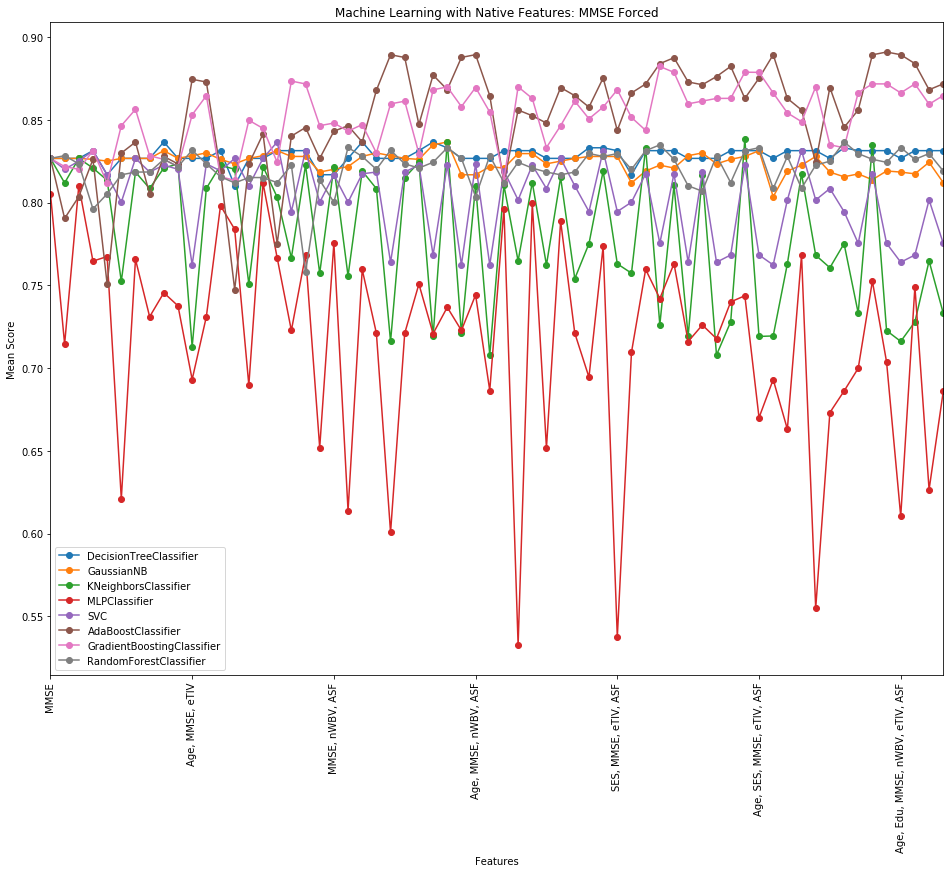

In [86]:
# Plot results with only MMSE
pkld_raw_full_onlyMMSE_mean = pkld_raw_full_onlyMMSE.xs('mean', level=1)

fig, ax = plt.subplots(figsize=(16, 12))
pkld_raw_full_onlyMMSE_mean.plot(style='o-', ax=ax)
plt.xticks(rotation=90)
plt.title('Machine Learning with Native Features: MMSE Forced')
plt.ylabel('Mean Score')
plt.xlabel('Features')
plt.legend(loc='best')
plt.show()

## <a id='conclusion'>Conclusion</a>

<p style='text-align: justify'>This study analyzed a dataset of 608 elderly patients and their corresponding clinical, behavioral, and magnetic resonance imaging data in an effort to develop machine learning models that can predict dementia diagnoses. The feature inputs chosen for machine learning algorithms were age, maximum education achieved, socioeconomic status, Mini-Mental State Examination score, normalized whole brain volume, estimated total intracranial volume, and atlas scaling factor. The dementia diagnosis targets were derived from the Clinical Dementia Rating, in which any CDR value greater than 0 indicated a positive dementia diagnosis. Prinicpal component analysis reduced the number of feature dimensions to 5, which successfully trained an adaptive boost classifier model to result in an cross-validated accuracy score of 89 $\pm$ 4%. The most informative feature dimension was the MMSE score, which alone could produce accuracies above 80%. Since MMSE is strongly correlated with CDR, machine learning models were trained without MMSE. These models produced a maximum accuracy of 82 $\pm$ 6%, which can decomposed into demographic (Age, Edu, SES) and MRI-derived (nWBV, eTIV, ASF) features with maximum accuracies of 68 $\pm$ 8% and 76 $\pm$ 4%, respectively.</p>

<p style='text-align: justify'>One of the primary obstacles for the implementation of machine learning approaches in clinical medicine is the health risk caused by incorrect computationally-derived diagnoses (Deo 2015). The models from this study would be inadequate to establish an automated dementia diagnosis service, as even 11% (with MMSE) or 18% (without MMSE) incorrect diagnoses would be unacceptable. However, with physician supervision, these models could have value as preliminary risk assessments, in which automated predictions could flag patients with increased risk of dementia according to their aggregated data. Furthermore, demographic data alone produced models that were accurate 2 out of 3 times, so these models could be useful for medical outreach to identify at-risk individuals before they are treated by a physician.</p>

<p style='text-align: justify'>It is important to note that the results of this study are complicated by a number of factors. First, the extremely limited sample size of 608 patients (570 for models using SES as an input) that is nonrepresentative of the elderly population as a whole. The sex ratio of the patients was uncharacteristically low (many more women than men) for the age group, and the fraction of patients with dementia is uncharacteristically high and far more common in men than women in the dataset. Furthermore, it is possible that sex-correlated features could have carried this bias into the machine learning models, thereby training against unrepresentative samples. For example, the eTIV feature, which is strongly influenced by the difference in brain size between men and women, could teach the algorithm that large eTIV values indicate higher likelihood of dementia, because greater than 50% of men in the dataset were diagnosed with dementia and men have larger eTIV values on average. Differences in mean Edu and SES between men and women could also subtley propagate sex-based data through the models. Finally, the data set used in the machine learning process included both cross-sectional and longitudinal data in nearly-equal amounts. The longitudinal data treated separate visits from the same patient as distinct samples, which may introduce bias through the replication of potentially-unrepresentative data points. Initial exploration of the data sets individually suggested that each data set was approximately equivalent in terms of feature value distribution, although the longitudinal data set included some extremely outliers. These outliers made an unknown impact on the overall model solutions.</p>

<p style='text-align: justify'>Further studies in this field would greatly benefit from the inclusion of PET or SPECT image data and much increased sample quantities in a distribution representative of the general elderly population. PET data was previously shown to be extremely useful in identifying the underlying pathology of dementia, such as $\beta$-amyloid plaque accumulation or brain damage from a stroke. Since these diseases precede overt dementia symptoms, PET and SPECT images can have immense predictive value. Combined with a measurement of brain atrophy, such as nWBV, it may be possible to pinpoint the precise stage of dementia as well as predict the near-term trajectory of the disease. It is also extremely important to use a large sample size of patients that accurately represents the elderly population, including sex ratio and dementia diagnosis percentages overall and between the sexes. An overall patient sample size in the tens of thousands would also significantly reduce the importance of training set selection and the impact of outlier data points. It is hoped that this study will encourage further effort in interdisciplinary medical data science to continue development of algorithms and approaches that can correlate a wide range of patient data into a single diagnosis.</p>

## <a id='acknowledgements'>Acknowledgements</a>
<p style='text-align: justify'>OASIS data was generated and made available to the public through support from the following grants: P50 AG05681, P01 AG03991, R01 AG021910, P50 MH071616, U24 RR021382, R01 MH56584.</p>

## <a id='references'>References</a>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>American Psychiatric Association. 2013. Diagnostic and statistical manual of mental disorders: DSM-5. 5th Ed. Washington, DC: American Psychiatric Association. pp. 591-603. ISBN 978-0-89042-554-1</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Bonte FJ, Harris TS, Hynan LS, Bigio EH, White CL. 2006. Tc-99m HMPAO SPECT in the differential diagnosis of the dementias with histopathologic confirmation. Clinic Nucl Med 31: 376-378. [doi: 10.1097/01.rlu.0000222736.81365.63](https://doi.org/10.1097/01.rlu.0000222736.81365.63)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Buckner RL, Head D, Parker J, Fotenos AF, Marcus D, Morris JC, Snyder AZ. 2004. A unified approach for morphometric and functional data analysis in young, old, and demented adults using automated atlas-based head size normalization: Reliability and validation against manual measurement of total intracranial volume. Neuroimage 23: 724-738. [doi: 10.1016/j.neuroimage.2004.06.018](https://doi.org/10.1016/j.neuroimage.2004.06.018)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Budson A, Solomon P. 2011. Memory loss: A practical guide for clinicians. Elsevier Saunders. ISBN 978-1-4160-3597-9.</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Burns A. 2009. Dementia. BMJ 338: b75. [doi: 10.1136/bmj.b75](https://doi.org/10.1136/bmj.b75)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Deo RC. 2015. Machine learning in medicine. Circulation 132: 1920-1930. [doi: 10.1161/CIRCULATIONAHA.115.001593](https://doi.org/10.1161/CIRCULATIONAHA.115.001593)
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Folstein MF, Folstein SE, McHugh PR. 1975. Mini-mental status: A practical method for grading the cognitive state of patients for the clinician. J Pyschiat Res 12: 189-198. [doi: 10.1016/0022-3956(75)90026-6](https://doi.org/10.1016/0022-3956(75)90026-6)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Fotenos AF, Snyder AZ, Girton LE, Morris JC, Buckner RL. 2005. Normative estimates of cross-sectional and longitudinal brain volume decline in aging and AD. Neurology 64: 1032-1039. [doi: 10.1212/01.WNL.0000154530.72969.11](https://doi.org/10.1212/01.WNL.0000154530.72969.11)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Hardy J, Allsop D. 1991. Amyloid deposition as the central event in aetiology of Alzheimer's disease. Trends Pharmacol Sci 12: 383-388. [doi: 10.1016/0165-6147(91)90609-V](https://doi.org/10.1016/0165-6147(91)90609-V)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Hurd MD, Martorell P, Delavande A, Mullen KJ, Langa KM. 2013. Monetary costs of dementia in the United States. N Engl J Med 368: 1326-1334. [doi: 10.1056/NEJMsal204629](https://doi.org/10.1056/NEJMsal204629)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Loy CT, Schofield PR, Turner AM, Kwok JB. 2014. Genetics of dementia. Lancet 383: 828-840. [doi: 10.1016/S0140-6736(13)60630-3](https://doi.org/10.1016/S0140-6736(13)60630-3)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Marcus DS, Wang TH, Parker J, Csernansky JG, Morris JC, Buckner RL. 2007. Open Access Series of Imaging Studies (OASIS): Cross-sectional MRI data in young, middle aged, nondemented, and demented older adults. J Cognitive Neurosci 19: 1498-1507. [doi: 10.1162/jocn.2007.19.9.1498](https://doi.org/10.1162/jocn.2007.19.9.1498)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Marcus DS, Fotenos AF, Csernansky JG, Morris JC, Buckner RL. 2010. Open Access Series of Imaging Studies (OASIS): Longitudinal MRI data in nondemented and demented older adults. J Cognitive Neurosci 22: 2677-2684. [doi: 10.1162/jocn.2009.21407](https://doi.org/10.1162/jocn.2009.21407)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Mielke MM. 2018. Sex and gender differences in Alzheimer Disease dementia. Psychiatric Times 35. [Link](https://www.psychiatrictimes.com/special-reports/sex-and-gender-differences-alzheimer-disease-dementia)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Morris JC. 1993. The Clinical Dementia Rating (CDR): Current version and scoring rules. Neurology 43: 2412b-2414b. [doi: 10.12.12/WNL.43.11.2412-a](https://doi.org/10.1212/WNL.43.11.2412-a)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Pangman VC, Sloan J, Guse L. 2000. An examination of psychometric properties of the Mini-Mental State Examination and the Standardized Mini-Mental State Examination: Implications for clinical practice. Appl Nurs Res 13: 209-213. [doi: 10.1053/apnr.2000.9231](https://doi.org/10.1053/apnr.2000.9231)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Prince M, Bryce R, Albanese E, Wimo A, Ribeiro W, Ferri CP. 2013. The global prevalence of dementia: A systematic review and metaanalysis. Alzheimers Dement 9: 63-75. [doi: 10.1016/j.alz.2012.11.007](https://doi.org/10.1016/j.alz.2012.11.007)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Rockwood K, Strang D, MacKnight C, Downer R, Morris JC. 2000. Interrater reliability of the Clinical Dementia Rating in a multicenter trial. J Am Geriatr Soc 48: 558-559. [doi: 10.1111/j.1532-5415.2000.tb05004.x](https://doi.org/10.1111/j.1532-5415.2000.tb05004.x)
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Tombaugh TN, McIntyre NJ. 1992. The Mini-Mental State Examination: A comprehensive review. J Am Geriatr Soc 40: 922-935. [doi: 10.1111/j.1532-5415.1992.tb01992.x](https://doi.org/10.1111/j.1532-5415.1992.tb01992.x)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Tuijl JP, Scholte EM, deCraen AJM, van der Mast RC. 2012. Screening for cognitive impairment in older general hospital patients: Comparison of the six-item cognitive test with the Mini-Mental State Examination. Int J Geriatr Psych 27: 755-762. [doi: 10.1002/gps.2776](https://doi.org/10.1002/gps.2776)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Valotassiou, V, Malamitsi J, Paptriantafyllou J, Dardiotis E, Tsougos I, Psimadas D, Alexiou S, Hadjigeorgiou G, Georgoulias P. 2018. Ann Nucl Med 32: 583. [doi: 10.1007/s12149-018-1292-6](https://doi.org/10.1007/s12149-018-1292-6)</p>